In [68]:
from lib import data_loaders
from lib import dendra_berkeley
from lib import groundwater_qc

import missingno as msno
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os
import requests
import pandas as pd
import time
import json
import pandas as pd

In [8]:
load_dotenv()
dendra_pass = os.getenv("DENDRA_PASS")
Dendra = data_loaders.Dendra(email="dragar@lynker.com", password=dendra_pass)

successfully authenticated


In [9]:
# parameters: start and end time
# Note the queries default to local time. Add a captial 'Z' to the end of the timestamp to indicate UTC and many functions have a parameter for local vs utc
begins_at = "2023-01-01T00:00:00"
ends_before = (
    dendra_berkeley.time_format()
)  # time_format without argument gives current datetime. #'2020-03-01T00:00:00'

In [10]:
# Note the change of measurements var from "WellDepth", which is used above and does not contain ranchbot data, to "WaterDepth",
# which is used here and ONLY returns datastreams with ranchbot data!

measurement = "WaterDepth"
# measurement = "AirTemperature"
query_refinement = {"is_hidden": False}
measurement_list = []  # list of only datastreams that you wish to download data from

ranchbot_ids = Dendra.list_datastreams_by_measurement(
    measurement, "", [], "tnc", query_refinement
)

In [ ]:
for id in ranchbot_ids:
    print(id["_id"])

    res, dstream_name = Dendra.get_datapoints(
        begins_at="1980-01-01T00:00:00",
        datastream_id=id["_id"],
        ends_before="2024-10-01T00:00:00",
        # name="other",
    )

    print(res)

    # serialize vaild reponses as Parquet
    if res is not None:

        # add station id to dataframe
        res["stn_id_dendra"] = id["_id"]

        # request metadata for each datastream
        dsm = Dendra.get_meta_datastream_by_id(
            datastream_id=id["_id"],
        )
        print(dsm)
        # create filename based on stn name and dstream name
        metadata_fname = dsm["name"].replace(" ", "_") + "_Metadata.json"
        metadata_fname = metadata_fname.replace(
            "/", "_"
        )  # must not have slash in filename

        stn_name = dsm["station_lookup"]["name"].replace(" ", "_")
        dstream_name = dsm["name"].replace(" ", "_")

        # print(f"{dstream_name=}")
        # print(
        #     f"out path: ./output/tnc_datastreams_v3/{
        #     stn_name}/{dstream_name}.parquet"
        # )

        res["stn_name"] = stn_name

        res.to_parquet(
            f"./output/tnc_datastreams_v3/{
                stn_name}/{dstream_name}.parquet"
        )

        time.sleep(15)

In [47]:
dfs = groundwater_qc.read_filtered_parquet_directory(
    directory_path="/Users/dillonragar/github/TNC_dangermond/station_data/output/tnc_datastreams_v3/"
)

Dangermond_Oaks_5
Dangermond_Escondido_5
Dangermond_Lower_Jalama_Vaqueros
Dangermond_Escondido_2
Dangermond_Tinta_2
Dangermond_Escondido_3
Dangermond_Tinta_5
Dangermond_Tinta_6


In [65]:
dfs["Dangermond_Lower_Jalama_Vaqueros"]["default"]

timestamp_local
2024-05-08 22:05:54    111.11
2024-05-09 01:06:31    111.11
2024-05-09 04:07:09    111.11
2024-05-09 07:07:46    111.11
2024-05-09 10:08:24    111.11
                        ...  
2024-09-30 10:23:30    111.11
2024-09-30 13:24:13    111.11
2024-09-30 16:24:48    111.11
2024-09-30 19:25:25    111.11
2024-09-30 22:26:02    111.11
Name: default, Length: 1156, dtype: float64

2024-05-08 23:11:43: 2024-09-30 22:08:42
2024-05-08 22:48:58: 2024-09-30 20:24:55
2024-05-08 22:05:54: 2024-09-30 22:26:02
2024-05-08 23:43:55: 2024-09-30 21:35:02
2024-05-08 21:06:57: 2024-06-20 14:14:53
2024-05-08 21:46:58: 2024-09-30 23:54:53
2024-05-08 21:26:29: 2024-09-30 22:21:25
2024-05-08 23:02:47: 2024-09-30 21:21:49


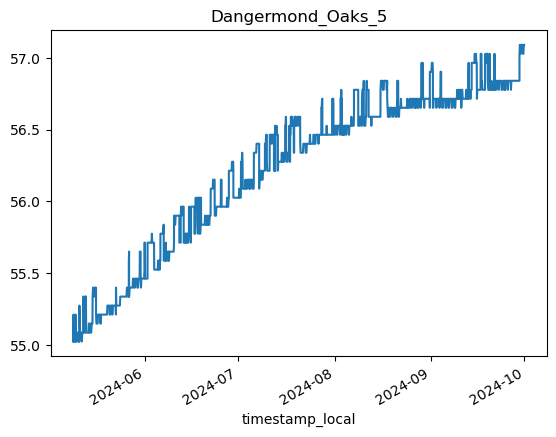

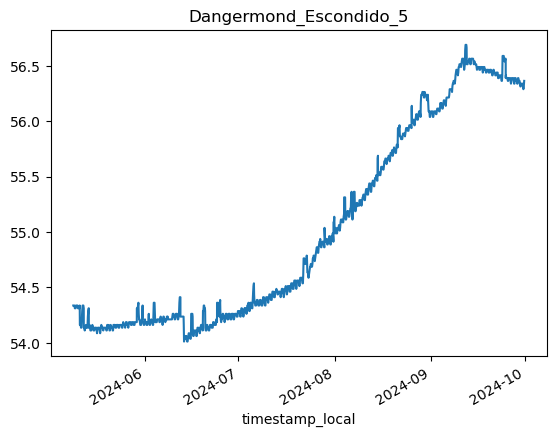

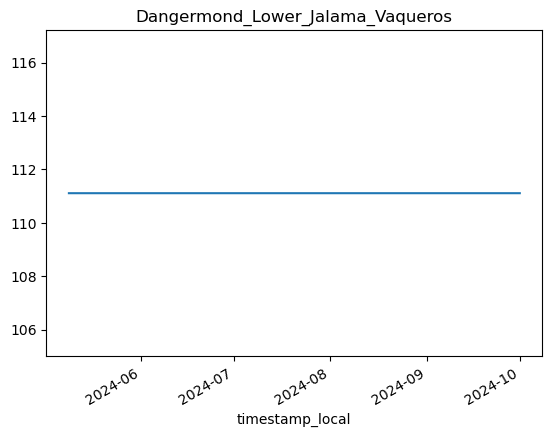

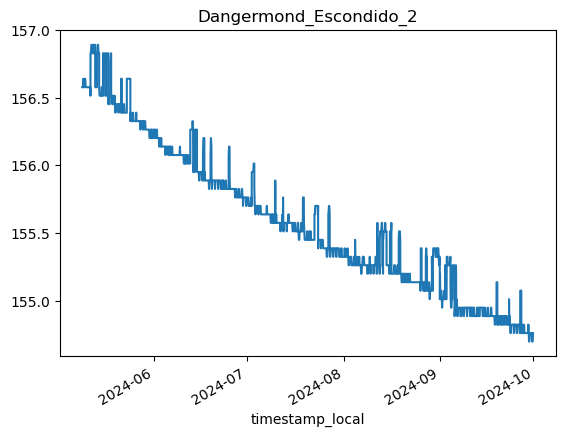

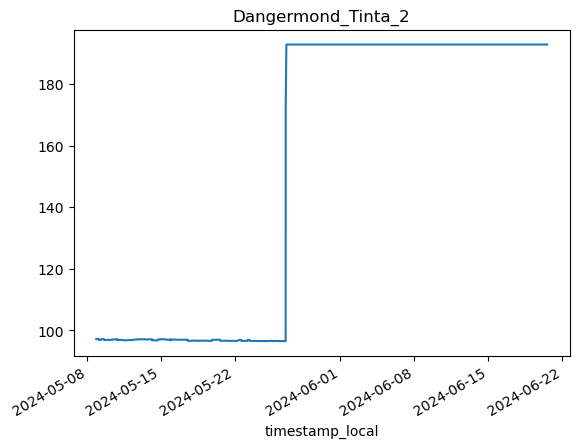

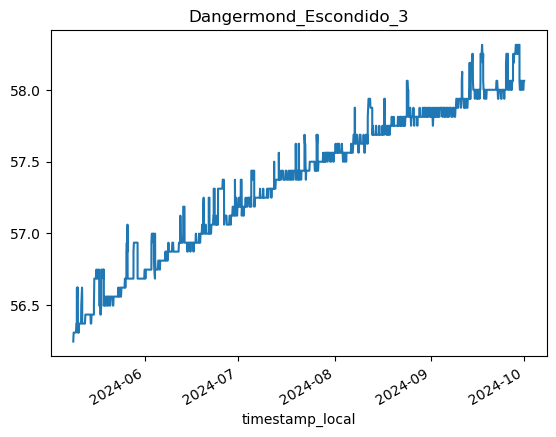

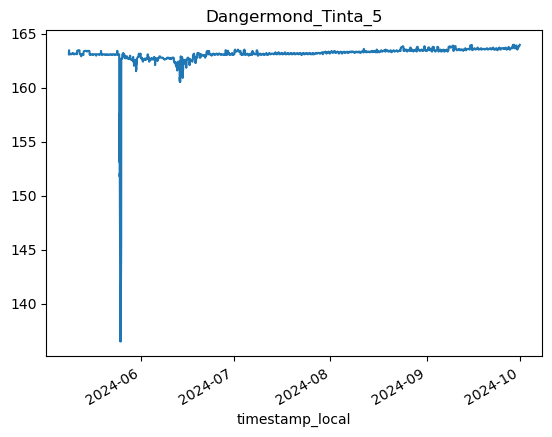

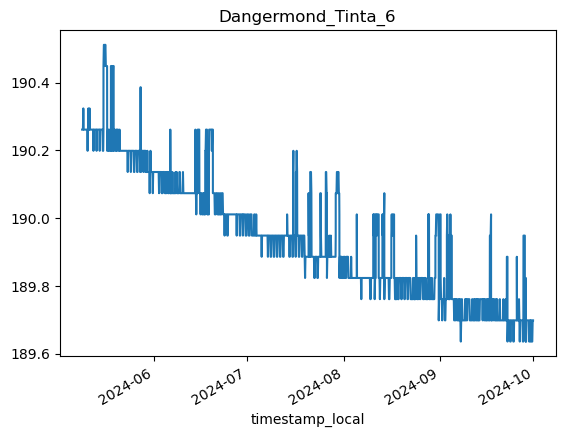

In [67]:
for name, df in dfs.items():
    plt.figure()
    df["default"].plot(title=name)
    print(f"{df.index.min()}: {df.index.max()}")